In [273]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

def inverse(f, domain=(0.0, 1.0-1e-6), extrapolate=(float("NaN"), float("NaN"))):
    def inner(x):
        if f(domain[0]) >= x:
            return extrapolate[0]
        if f(domain[1]) <= x:
            return extrapolate[1]
        else:
            try:
                return scipy.optimize.brentq(lambda y: f(y)-x, a=domain[0], b=domain[1])
            except ValueError:
                return float("NaN")

    return np.vectorize(inner)

import scipy.misc
def derivative(f, dx=1e-6):
    return np.vectorize(lambda x: scipy.misc.derivative(f, x, dx))

def lorenz(f, ymin, ymax, ymean):
    finv = inverse(f, (ymin, ymax))
    return np.vectorize(lambda p: scipy.integrate.quad(finv, 0, p)[0] / ymean)

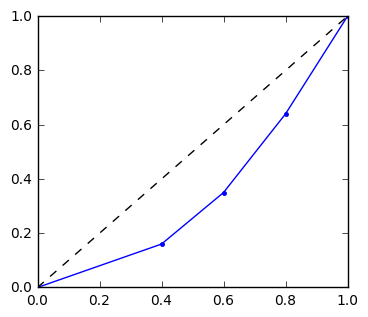

In [274]:
##########################################
plt.rcParams["figure.figsize"] = (4,3.5)
##########################################

# Observed points of the Lorenz curve and population parameters
p = [0.0, 0.4, 0.6, 0.8,  1.0]
L = [0.0, 0.16, 0.35, 0.64, 1.0]
ymean = 10.0

# Grids for plotting
xgrid = np.linspace(0, 1, 1000)
ygrid = np.linspace(0, 2*mean, 1000)

plt.plot(p, L, '.-')
plt.plot((0,1),(0,1),"k--");

We define a Lorenz curve with 5 observed points $(L_i, p_i)$ for $i \in 0, 1, 2, 3, 4 = k$ so that a single cubic cannot fit the implied CDF (except by chance). Then four spline segments of the CDF are defined, each as:

$$
F(y) = a_i y^3 + b_i y^2 + c_i y + d_i,\qquad \mathrm{for}\quad y_{i-1} < y \leq y_i
$$

Then we have a total of $4k-3$ interior constraints:
- $k$ integral (Lorenz) constraints
- $k-1$ point constraints (continuity)
- $k-1$ first derivative constraints ($C^1$)
- $k-1$ second derivative constraints ($C^2$)

and we choose 4 further endpoint constraints from amongst the following:
- endpoint constraints $y_\min$, $y_\max$
- endpoint derivative constraints $f(y_\min)$, $f(y_\max)$
- endpoint second derivative constraints $f'(y_\min)$, $f'(y_\max)$

We can initialise all of these constraints with a least-squares fit as a good initial guess, using the midpoint fit as in the direct cubic spline interpolation.

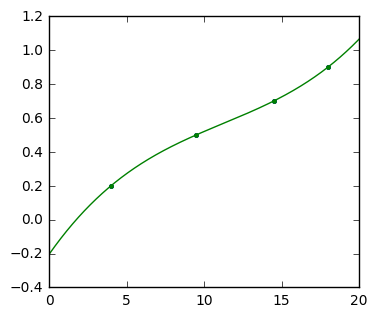

In [266]:
# The y values are simply the mean-scaled derivatives of the Lorenz curve
dL = np.diff(L)
dp = np.diff(p)
y = ymean * dL/dp
#y = np.hstack((0.0, y))

# And we arbitrarily assign these y values to the mid-points of the p values
pmid = np.add(p[1:],p[:-1])/2
#pmid = np.hstack((0.0, pmid))

plt.plot(y, pmid, 'b.')

# Find the least squares fit
X = np.vstack((np.power(y, 3), np.power(y, 2), np.power(y, 1), np.power(y, 0)))

# bX = y
import numpy.linalg
coef = numpy.linalg.lstsq(np.transpose(X), np.transpose(pmid))[0]

lscubic = lambda y: np.matmul(coef, np.vstack((np.power(y, 3), np.power(y, 2), np.power(y, 1), np.power(y, 0))))

plt.plot(ygrid, lscubic(ygrid), 'g-');

yknots = inverse(lscubic, (0, 20))(pmid).tolist()
plt.plot(yknots, pmid, "g.")

Sure enough, the least square fit is imperfect. Now we use this curve to assign our starting values for all the segments.

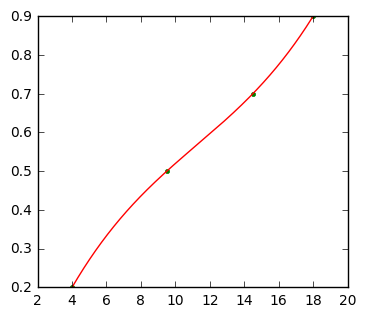

In [267]:
N_segments = len(pmid)-1

a = [coef[0]]*N_segments
b = [coef[1]]*N_segments
c = [coef[2]]*N_segments
d = [coef[3]]*N_segments

def make_cubic_spline(knots, a, b, c, d):
    def cubic_spline(x):
        if x < knots[0] or x > knots[-1]:
            return float("NaN")

        for i in range(0, len(knots)):
            if x < knots[i+1]:
                return a[i] * x**3 + b[i] * x**2 + c[i] * x**1 + d[i]
            
    return np.vectorize(cubic_spline)
        
# Confirm that the piecewise cubic spline is correctly defined
plt.plot(yknots, pmid, "g.")
plt.plot(ygrid, make_cubic_spline(yknots, a, b, c, d)(ygrid), 'r-')

In [268]:
def errfun(yknots, a, b, c, d):
    ymin, ymax = 2, 20
    f_ymin, f_ymax = 0, 0
    
    err_lorenz = 0
    err_point = 0
    err_d1 = 0
    err_d2 = 0
    err_endpoints = 0
    err_nonincr = 0
    
    for i in range(N_segments):
        lhs = L[i+1] - L[i]
        rhs = (3/4)*a[i]*(yknots[i+1] - yknots[i])**4 + (2/3)*b[i]*(yknots[i+1]-yknots[i])**3 + (1/2)*c[i]*(yknots[i+1]-yknots[i])**2
        err_lorenz += (lhs-rhs)**2
        
    for i in range(N_segments-1):
        lhs = a[i]*yknots[i+1]**3 + b[i]*yknots[i+1]**2 + c[i]*yknots[i+1]**1 + d[i]
        rhs = a[i+1]*yknots[i+1]**3 + b[i+1]*yknots[i+1]**2 + c[i+1]*yknots[i+1]**1 + d[i+1]
        err_point += (lhs-rhs)**2
        
    for i in range(N_segments-1):
        lhs = 3*a[i]*yknots[i+1]**2 + 2*b[i]*yknots[i+1]**1 + c[i]
        rhs = 3*a[i+1]*yknots[i+1]**2 + 2*b[i+1]*yknots[i+1]**1 + c[i+1]
        err_d1 += (lhs-rhs)**2
        
    for i in range(N_segments-1):
        lhs = 6*a[i]*yknots[i+1] + 2*b[i]
        lhs = 6*a[i+1]*yknots[i+1] + 2*b[i+1]
        err_d2 += (lhs-rhs)**2
        
    err_endpoints += (
        (a[0]*ymin**3 + b[0]*ymin**2 + c[0]*ymin**1 + d[0]*ymin**0 - 0.0) ** 2 +
        (a[-1]*ymax**3 + b[-1]*ymax**2 + c[-1]*ymax**1 + d[-1]*ymax**0 - 1.0) ** 2 +
        (6*a[0]*ymin + 2*b[0] - f_ymin) ** 2 +
        (6*a[-1]*ymax + 2*b[-1] - f_ymax) ** 2
    )
    
    d1_grid = [3*a[i]*y**2 + 2*b[i]*y**1 + c[i] for y in np.linspace(ymin, ymax, 100)]
    d1_grid_negs = -sum([p for p in d1_grid if p < 0])
    err_nonincr = 10 * d1_grid_negs
    
    #print("errors:", err_lorenz, err_point, err_d1, err_d2, err_endpoints)
    return err_lorenz + err_point + err_d1 + err_d2 + err_endpoints + err_nonincr

def collapse_args(yknots, a, b, c, d):
    return yknots + a + b + c + d

def extract_args(args):
    if isinstance(args, list):
        args = np.array(args)
    xyknots, args = args[:len(yknots)], args[len(yknots):]
    xa, args = args[:len(a)], args[len(a):]
    xb, args = args[:len(b)], args[len(b):]
    xc, args = args[:len(c)], args[len(c):]
    xd, args = args[:len(d)], args[len(d):]
    return xyknots.tolist(), xa.tolist(), xb.tolist(), xc.tolist(), xd.tolist()

def errfun_wrapper(args):
    return errfun(*extract_args(args))

In [269]:
errfun(yknots, a, b, c, d)
errfun_wrapper(collapse_args(yknots, a, b, c, d))

1.9859775161236837

In [270]:
import scipy.optimize
result = scipy.optimize.minimize(errfun_wrapper,collapse_args(yknots, a, b, c, d))
yknots, a, b, c, d = extract_args(result.x)
errfun(yknots, a, b, c, d)

0.0054488649832662456

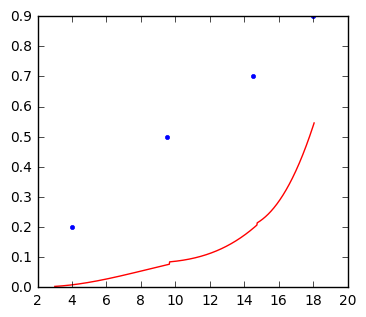

In [271]:

plt.plot(y, pmid, 'b.')
plt.plot(ygrid, make_cubic_spline(yknots, a, b, c, d)(ygrid), 'r-')
#plt.plot(ygrid, a[-1]*ygrid**3 + b[-1]*ygrid**2 + c[-1]*ygrid**1 + d[-1]*ygrid**0)

In [272]:
i = 2
lhs = L[i+1] - L[i]
rhs = (3/4)*a[i]*(yknots[i+1] - yknots[i])**4 + (2/3)*b[i]*(yknots[i+1]-yknots[i])**3 + (1/2)*c[i]*(yknots[i+1]-yknots[i])**2
print(lhs, rhs)

0.29000000000000004 0.28798342520347586


/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose 

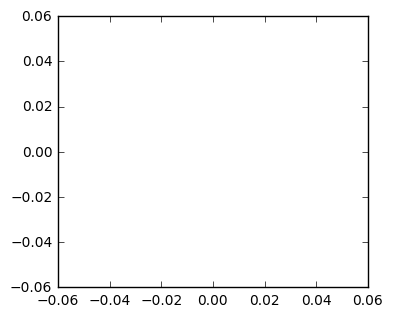

In [282]:
plt.plot(xgrid, lorenz(make_cubic_spline(yknots, a, b, c, d), 3, 18, ymean)(xgrid))
#plt.plot(xgrid, inverse(make_cubic_spline(yknots, a, b, c, d), (3, 18), (0,1))(xgrid))